In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions import Categorical
from multiprocessing_env import SubprocVecEnv

from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import time

#CUDA
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
use_cuda,device

(False, device(type='cpu'))

In [2]:
#Number on envs we'll be running in parallel
num_envs = 8
env_name = "MountainCarContinuous-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

In [3]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)


In [4]:
#Neural Net
#ActorCritic, for continuous action tasks
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        #self.log_std only for continuous action spaces.
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        #only difference is we're using Normal dist to sample actions from
        #Gaussian distribution. Categorical() for discrete action space.
        dist  = Normal(mu, std)
        return dist, value

In [5]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [6]:
#GAE
#gamma is discount factor for returns, tau is smoothing factor of GAE algo.
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        #delta is Bellman equation minus value of the state
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        #moving average of advantages discounted by gamma * tau
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [7]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)   #pass state into network to get latest distribution and state value
            entropy = dist.entropy().mean() #for inciting exploration
            new_log_probs = dist.log_prob(action) #new log_probs of originally selected actions
            
            
            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage
            
            #CLIP LOSS
            actor_loss  = - torch.min(surr1, surr2).mean()
            #MSE LOSS between GAE returns and estimated value of the state
            critic_loss = (return_ - value).pow(2).mean()
            #discounted critic loss plus CLIP LOSS minus scaled entroy
            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [11]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 256   #neurons in hidden layer
lr               = 3e-4  #passed to Adam optimizer    
num_steps        = 1024   #num of transitions we sample for each training iter
mini_batch_size  = 16     #num of samples randomly selected from stored data
ppo_epochs       = 8     #num passes over entire training data
threshold_reward = 90  #we'll stop training when we reach this reward in evaluation

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

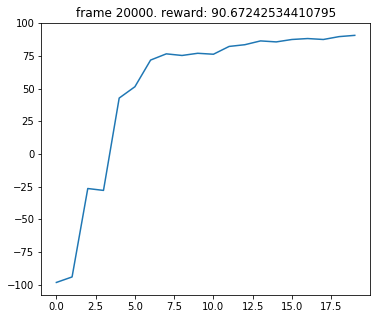

In [12]:
max_frames = 50000
frame_idx  = 0
test_rewards = []

state = envs.reset()
early_stop = False

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0
    
    #each step generate state, action, reward, next_state from each env.
    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device) 
        dist, value = model(state) #state through netwwork to get prob dist and estimated V(s)

        action = dist.sample()
        #state, reward, done is list of results, 1 per env
        #env.render()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        #Store log_probs, values, rewards, done_masks, states, actions. Each list num_steps long, each step num_envs wide.
        log_probs.append(log_prob) #
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True
            
    #to calc returns correctly, run final next_state through network to get value
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    #run GAE. Loop backwards from recent experience.
    returns = compute_gae(next_value, rewards, masks, values)
    
    #concatanate each list inside a torch tensor.
    #list that was num_steps long, num_envs wide becomes num_steps*num_envs long
    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)



In [14]:
#Save trajectories for GAIL
from itertools import count

max_expert_num = 10000
num_steps = 0
expert_traj = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        #Show
        
        #Take action
        
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        total_reward += reward
        expert_traj.append(np.hstack([state, action]))
        num_steps += 1
    
    print("episode:", i_episode, "reward:", total_reward)
    
    if num_steps >= max_expert_num:
        break
for _ in range(10):
    test_env(True)        
    time.sleep(3)       
expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
np.save("expert_traj_mntcarcont8.npy", expert_traj)



episode: 0 reward: 92.50595489693949
episode: 1 reward: 90.2429031923931
episode: 2 reward: 90.46213745210656
episode: 3 reward: 92.98511851341641
episode: 4 reward: 88.24416834781347
episode: 5 reward: 92.88827495482111
episode: 6 reward: 90.60765836455347
episode: 7 reward: 92.40094184886196
episode: 8 reward: 89.37611127103935
episode: 9 reward: 91.118402050449
episode: 10 reward: 89.98251751223295
episode: 11 reward: 93.99193749327159
episode: 12 reward: 92.23811835895602
episode: 13 reward: 88.81998365793334
episode: 14 reward: 89.05165064709018
episode: 15 reward: 91.89187652015232
episode: 16 reward: 91.68700199669784
episode: 17 reward: 90.31249531113625
episode: 18 reward: 92.62575449360881
episode: 19 reward: 93.5227400879799
episode: 20 reward: 88.48039546172757
episode: 21 reward: 92.26560479736753
episode: 22 reward: 90.7838209253255
episode: 23 reward: 91.81141319365696
episode: 24 reward: 89.4528686981365
episode: 25 reward: 86.02661005927848
episode: 26 reward: 93.17166